In [120]:
from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport


def buildQuery(url)->str:
    query = """{
        getRepository(repository: \""""+ url + """") {
        edges {
        node {
            created
            repository
            fileName
            branch
            wholeRepositoryAnalyzed
            metrics {
            edges {
                node {
                CommitTime
                CommitMessage
                CommitID
                ReadingError
                axioms
                reasonerActive
                logicalAxioms
                subClassOfAxioms
                inverseObjectPropertyAxioms
                objectPropertiesOnClasses
                OntoQA_Cohesion
                OntoQA_Relationship_Richness
                OntoQA_Relationship_Diversity
                OntoQA_Class_Utilization
                OntoQA_Class_Inheritance_Richness
                OntoQA_Attribute_Richness
                OntoQA_Schema_Deepness
                individuals
                classes
                classesWithIndividuals
                
                }
            }
            }
        }
        }
        }
        }
        """
    return query

async def fetchData(url: str)->list:
    endpoint = Client(transport=AIOHTTPTransport(url="http://localhost:8000/graphql"), fetch_schema_from_transport=True, execute_timeout=None)

    async with endpoint as session:
        query = gql(buildQuery(url))
        response = await session.execute(query)
        # The following part is for restrucuring the nested GraphQL responses into a flat table for further processing.
        unpackNodes = response["getRepository"]["edges"]
        unPivotArray =[]
        for element in unpackNodes:
            for metric in element["node"]["metrics"]["edges"]:
                newElement = {}
                newElement.update(metric["node"])
                newElement.update(element["node"])
                newElement.pop("metrics")
                unPivotArray.append(newElement)

        return unPivotArray
        


In [121]:
import pandas as pd
import seaborn as sns

data = await fetchData("github.com/evidenceontology/evidenceontology")
df = pd.DataFrame.from_dict(data)
df["CommitTime"]= pd.to_datetime(df["CommitTime"])
df.to_csv("data.csv")
print("Number of ontology files: "+ str(df.fileName.nunique()))

Number of ontology files: 17


In [122]:
# At first let's filter out all the values that are calculated with a reasoner. As most of the ontologies are quite large,
# inferred ontologies won't be available anyway, as reasoning is just supported for ontologies > 1mb.
dfWOReasoning = df[df["reasonerActive"] == False]
print(f"Length DataSet: {len(df)}, Length DataSet W/O reasoned ontologies: {len(dfWOReasoning)}")
df = dfWOReasoning

wOError = df[~df["OntoQA_Attribute_Richness"].isnull() & ~df["OntoQA_Relationship_Richness"].isnull() ]
print(f"count of Analysis Errors: {len(df)-len(wOError)}")
df = wOError

Length DataSet: 856, Length DataSet W/O reasoned ontologies: 856
count of Analysis Errors: 354


In [123]:
# Then let's filter all the ontologies that are used as imports and have the tag "import" in the filename.

df =df[~df["fileName"].str.contains("subset")]
df =df[~df["fileName"].str.contains("imports")]
df =df[~df["fileName"].str.contains("modules")]
df =df[~df["fileName"].str.contains("deprecated")]
df.groupby(df["fileName"]).count()

,CommitTime,CommitMessage,CommitID,ReadingError,axioms,reasonerActive,logicalAxioms,subClassOfAxioms,inverseObjectPropertyAxioms,objectPropertiesOnClasses,...,OntoQA_Class_Inheritance_Richness,OntoQA_Attribute_Richness,OntoQA_Schema_Deepness,individuals,classes,classesWithIndividuals,created,repository,branch,wholeRepositoryAnalyzed
fileName,,,,,,,,,,,,,,,,,,,,,
eco-base.owl,45,45,45,45,45,45,45,45,45,45,...,45,45,45,45,45,45,45,45,45,45
eco-basic.owl,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
eco.owl,89,89,89,89,89,89,89,89,89,89,...,89,89,89,89,89,89,89,89,89,89
src/ontology/eco-edit.owl,95,95,95,95,95,95,95,95,95,95,...,95,95,95,95,95,95,95,95,95,95


C:\Users\achim\AppData\Local\Temp\ipykernel_13220\2146271156.py:6: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  dfDraw = dfDraw.melt(id_vars=["Commit Time", "Ontology File"], var_name="Axiom Type", value_name="Axioms")


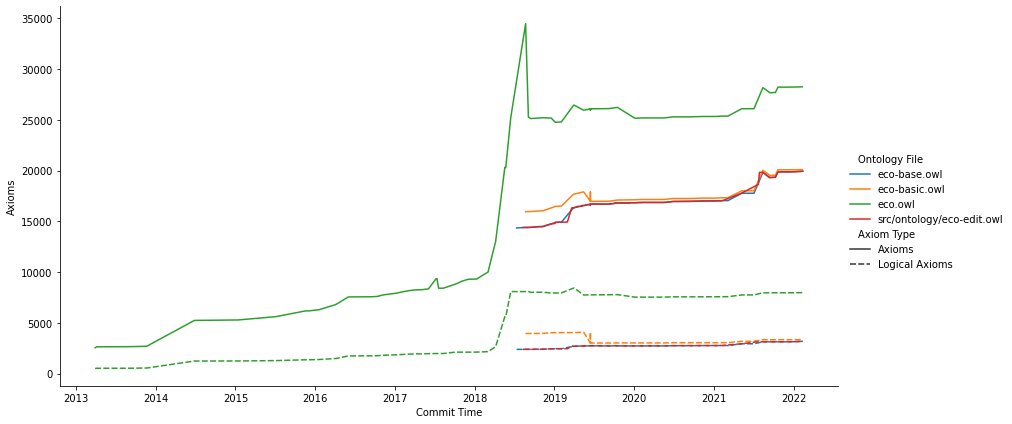

In [124]:
dfDraw = pd.DataFrame()
dfDraw["Commit Time"] = df["CommitTime"]
dfDraw["Axioms"] = df["axioms"]
dfDraw["Logical Axioms"] = df["logicalAxioms"]
dfDraw["Ontology File"] = df["fileName"]
dfDraw = dfDraw.melt(id_vars=["Commit Time", "Ontology File"], var_name="Axiom Type", value_name="Axioms")
#sns.relplot(x="Commit Time", y="Axioms", data=dfDraw, hue="Ontology File", height=6, aspect=2)
sns.relplot(x="Commit Time", y="Axioms", data=dfDraw, kind="line", hue="Ontology File",style="Axiom Type", height=6, aspect=2)

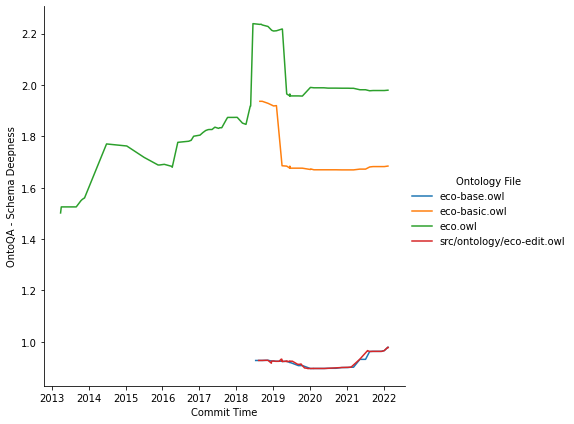

In [118]:
dfDraw = pd.DataFrame()
dfDraw["Ontology File"] = df["fileName"]
dfDraw["Commit Time"] = df["CommitTime"]
dfDraw["OntoQA - Schema Deepness"] = df["OntoQA_Schema_Deepness"]
sns.relplot(x="Commit Time", y="OntoQA - Schema Deepness", data=dfDraw, kind="line", hue="Ontology File", height=6, aspect=1)

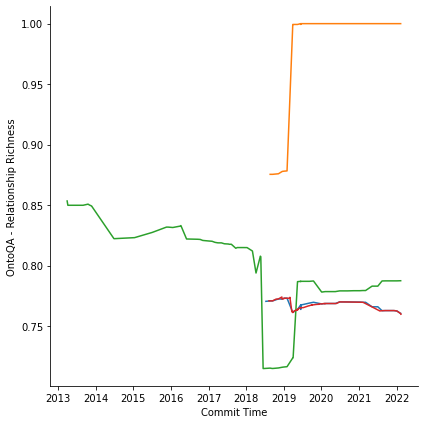

In [119]:
dfDraw = pd.DataFrame()
dfDraw["Ontology File"] = df["fileName"]
dfDraw["Commit Time"] = df["CommitTime"]
dfDraw["OntoQA - Relationship Richness"] = df["OntoQA_Relationship_Richness"]
sns.relplot(x="Commit Time", y="OntoQA - Relationship Richness", data=dfDraw, kind="line", hue="Ontology File", height=6, aspect=1, legend=False)

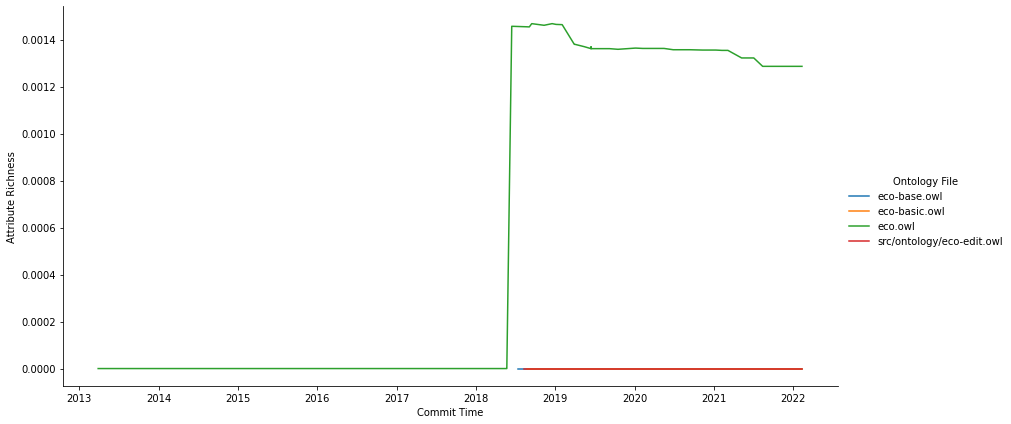

In [73]:
dfDraw = pd.DataFrame()
dfDraw["Ontology File"] = df["fileName"]
dfDraw["Commit Time"] = df["CommitTime"]
dfDraw["Attribute Richness"] = df["OntoQA_Attribute_Richness"]
sns.relplot(x="Commit Time", y="Attribute Richness", data=dfDraw, kind="line", hue="Ontology File", height=6, aspect=2)

In [ ]:
dfDraw = pd.DataFrame()
dfDraw["Ontology File"] = df["fileName"]
dfDraw["Commit Time"] = df["CommitTime"]
dfDraw["Schema Deepness"] = df["OntoQA_Schema_Deepness"]
sns.relplot(x="Commit Time", y="Schema Deepness", data=dfDraw, kind="line", hue="Ontology File", height=6, aspect=2)